## 그래프의 한글 폰트

In [ ]:
!sudo apt install -y fonts-nanum*
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20200506-1).
fonts-nanum-coding is already the newest version (2.5-3).
fonts-nanum-eco is already the newest version (1.000-7).
fonts-nanum-extra is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts,

In [ ]:
# 런타임 -> 세션 다시 시작 후 실행
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

## 학습 내용
1. 원핫인코딩(One-Hot Encoding)의 이해와 적용

    * 범주형 변수(지역명)를 딥러닝 모델이 이해할 수 있는 수치형 데이터로 변환
    * 범주 간 관계가 없는 데이터를 효과적으로 표현하는 방법


2. 특성 스케일링(Feature Scaling)의 필요성

    * 서로 다른 스케일을 가진 특성들(면적, 건축년도, 침실수)을 조정
    * 모델 학습의 안정성과 성능 향상을 위한 전처리 과정


3. 복잡한 데이터에 대한 신경망 모델 구축

    * 수치형 변수와 범주형 변수를 결합한 입력 데이터 처리
다양한 변수가 결과에 미치는 영향 분석

4. 활성화 함수에 대한 이해

    * ReLU, Swish 등 다양한 활성화 함수가 언제 쓰이고 어떻게 활용할 수 있는지 확인

## 데이터와 모듈 준비

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 데이터 준비: 주택 가격 예측 데이터
면적 = [85, 100, 75, 120, 150, 90, 110, 130, 95, 140]  # 단위: 제곱미터
침실수 = [2, 2, 1, 3, 4, 2, 3, 3, 2, 4]
건축년도 = [2005, 2010, 2000, 2015, 2018, 2008, 2012, 2017, 2007, 2020]
지역 = ['강남', '홍대', '강남', '영등포', '송파', '홍대', '영등포', '송파', '강남', '송파']  # 범주형 변수
가격 = [650, 720, 500, 850, 1200, 680, 780, 950, 700, 1100]  # 단위: 백만원

In [ ]:
# 데이터프레임 생성
df = pd.DataFrame({
    '면적': 면적,
    '침실수': 침실수,
    '건축년도': 건축년도,
    '지역': 지역,
    '가격': 가격
})

df

,면적,침실수,건축년도,지역,가격
0,85,2,2005,강남,650
1,100,2,2010,홍대,720
2,75,1,2000,강남,500
3,120,3,2015,영등포,850
4,150,4,2018,송파,1200
5,90,2,2008,홍대,680
6,110,3,2012,영등포,780
7,130,3,2017,송파,950
8,95,2,2007,강남,700
9,140,4,2020,송파,1100


<ipython-input-5-1e76e33434cf>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='지역', y='가격', data=df, ci=None)


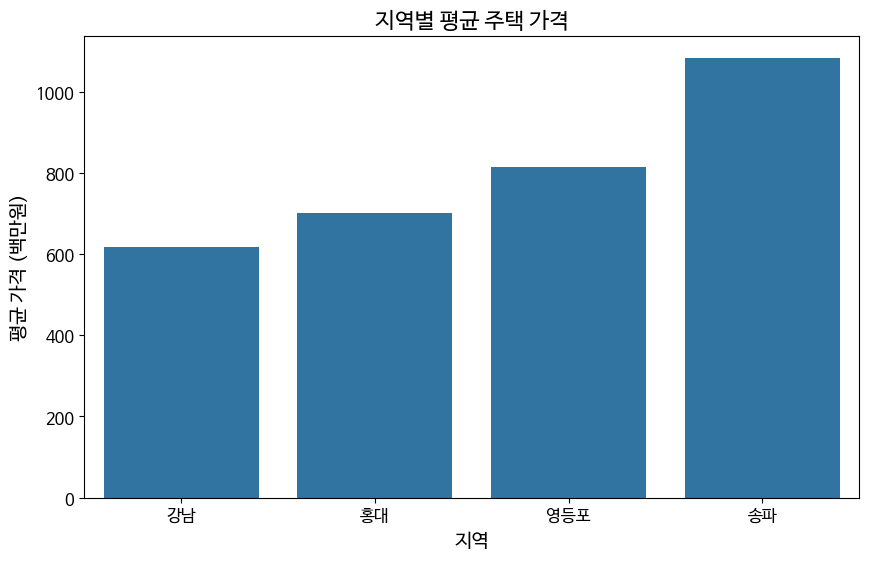

In [ ]:
# 1. 지역별 평균 가격 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='지역', y='가격', data=df, ci=None)
plt.title('지역별 평균 주택 가격', fontsize=16)
plt.xlabel('지역', fontsize=14)
plt.ylabel('평균 가격 (백만원)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('지역별_평균가격.png')
plt.show()

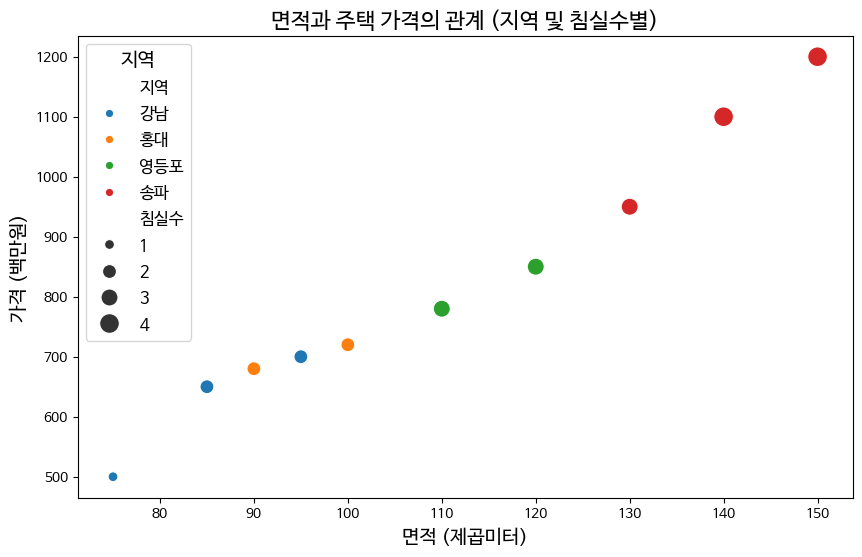

In [ ]:
# 2. 면적과 가격의 산점도 (지역별 색상 구분)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='면적', y='가격', hue='지역', size='침실수', sizes=(50, 200), data=df)
plt.title('면적과 주택 가격의 관계 (지역 및 침실수별)', fontsize=16)
plt.xlabel('면적 (제곱미터)', fontsize=14)
plt.ylabel('가격 (백만원)', fontsize=14)
plt.legend(title='지역', fontsize=12, title_fontsize=14)
plt.savefig('면적_가격_산점도.png')
plt.show()

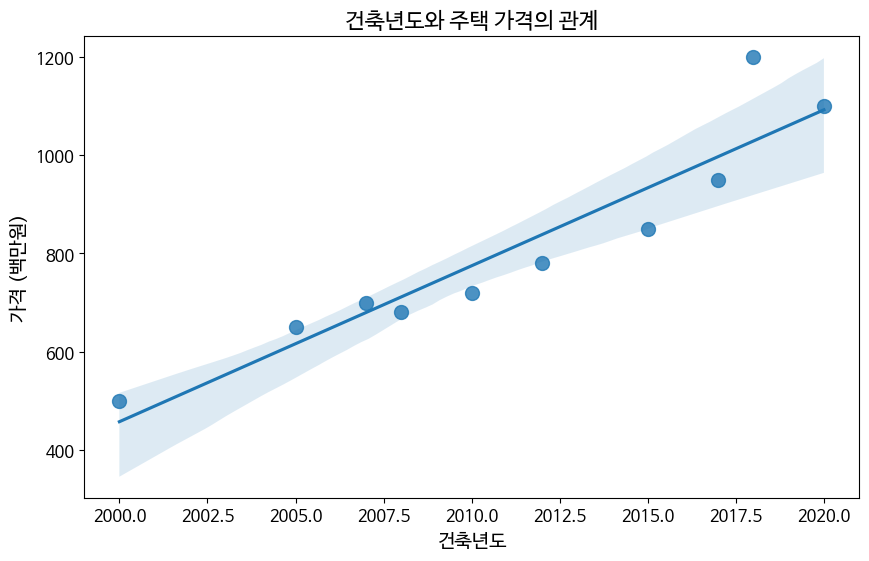

In [ ]:
# 3. 건축년도와 가격의 관계
plt.figure(figsize=(10, 6))
sns.regplot(x='건축년도', y='가격', data=df, scatter_kws={'s': 100})
plt.title('건축년도와 주택 가격의 관계', fontsize=16)
plt.xlabel('건축년도', fontsize=14)
plt.ylabel('가격 (백만원)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('건축년도_가격.png')
plt.show()

## 데이터 세팅 및 딥러닝

In [ ]:
# 실습 1: 지역 컬럼에 원핫인코딩 적용하기
# pandas의 get_dummies 사용
one_hot_지역 = pd.get_dummies(df['지역'], prefix='지역')
one_hot_지역

,지역_강남,지역_송파,지역_영등포,지역_홍대
0,True,False,False,False
1,False,False,False,True
2,True,False,False,False
3,False,False,True,False
4,False,True,False,False
5,False,False,False,True
6,False,False,True,False
7,False,True,False,False
8,True,False,False,False
9,False,True,False,False


In [ ]:
# 독립변수와 종속변수 준비
독립변수_수치 = df[['면적', '침실수', '건축년도']]
독립변수_원핫 = one_hot_지역
독립변수_전체 = pd.concat([독립변수_수치, 독립변수_원핫], axis=1)

종속변수 = df[['가격']]

In [ ]:
종속변수
독립변수_전체

,면적,침실수,건축년도,지역_강남,지역_송파,지역_영등포,지역_홍대
0,85,2,2005,True,False,False,False
1,100,2,2010,False,False,False,True
2,75,1,2000,True,False,False,False
3,120,3,2015,False,False,True,False
4,150,4,2018,False,True,False,False
5,90,2,2008,False,False,False,True
6,110,3,2012,False,False,True,False
7,130,3,2017,False,True,False,False
8,95,2,2007,True,False,False,False
9,140,4,2020,False,True,False,False


In [ ]:
# 실습 2: 특성 스케일링 (선택 사항)
# 특성들의 스케일이 매우 다르므로 스케일링 적용
독립변수_수치_스케일링 = 독립변수_수치.copy()
독립변수_수치_스케일링['면적'] = 독립변수_수치_스케일링['면적'] / 100
독립변수_수치_스케일링['건축년도'] = (독립변수_수치_스케일링['건축년도'] - 2000) / 20

In [ ]:
독립변수_전체_스케일링 = pd.concat([독립변수_수치_스케일링, 독립변수_원핫], axis=1)

In [ ]:
print("스케일링 적용 후 독립변수:")
독립변수_전체_스케일링

스케일링 적용 후 독립변수:


,면적,침실수,건축년도,지역_강남,지역_송파,지역_영등포,지역_홍대
0,0.85,2,0.25,True,False,False,False
1,1.00,2,0.50,False,False,False,True
2,0.75,1,0.00,True,False,False,False
3,1.20,3,0.75,False,False,True,False
4,1.50,4,0.90,False,True,False,False
5,0.90,2,0.40,False,False,False,True
6,1.10,3,0.60,False,False,True,False
7,1.30,3,0.85,False,True,False,False
8,0.95,2,0.35,True,False,False,False
9,1.40,4,1.00,False,True,False,False


In [ ]:
독립변수_전체_스케일링.shape[1]

7

In [ ]:
# 실습 3: 원핫인코딩을 포함한 신경망 모델 구축하기
# 입력 형태 정의 (수치형 3개 + 원핫인코딩 변수)
X = tf.keras.layers.Input(shape=[독립변수_전체_스케일링.shape[1]])

# 히든 레이어 - 2개의 레이어, 첫 번째는 10개 노드, 두 번째는 5개 노드
H = tf.keras.layers.Dense(10, activation='relu')(X)
H = tf.keras.layers.Dense(5, activation='relu')(H)

# 출력 레이어
Y = tf.keras.layers.Dense(1)(H)

# 모델 생성 및 컴파일
model = tf.keras.models.Model(X, Y)
model.compile(loss='mse', optimizer='adam')

### 주요 활성화 함수

신경망에서는 입력을 그대로 다음 레이어로 전달하지 않고 가중치가 반영된 합을 모아 활성화 함수를 통과 시켜 다음 레이어로 전달합니다. 쉽게 얘기하면 활성화 함수는 입력 신호의 합을 출력신호로 만드는 함수입니다.

이러한 활성화 함수가 왜 필요할까요? 앞서 배운 y = wx + b의 형태는 아무리 많이 쌓아도 y = W₂(W₁x + b₁) + b₂는 y = (W₂W₁)x + (W₂b₁ + b₂)와 같은 형태가 됩니다. 하나의 선형 층(Linear Layer)이 되는 것이죠. 여기서 선형층이란 수학적으로 y = wx + b의 형태가 되는 것을 얘기합니다. 직선 형태가 되는 것이죠. 그런데 현실 문제는 대부분 비선형적 관계를 가집니다. 이를 가능하게 하는 것이 활성화 함수인것이죠.

예를 들어, y = W₂(W₁x + b₁) + b₂ = (W₂W₁)x + (W₂b₁ + b₂)는 비선형 활성화 함수(예: ReLU)를 도입하면 y = W₂(σ(W₁x + b₁)) + b₂형태를 만들 수 있습니다. 좀 더 복잡한 함수를 표현할 수 있게 된 것이죠.

```
# 절대값과 다릅니다. 음수를 0으로 만듭니다. 이는 생물학적 뉴런과의 유사성이 있습니다. 뉴런은 특정 임계값 이하에서는 활성화되지 않고, 임계값 이상에서는 선형적으로 반응합니다. 이밖에도 수학적인 실용적 장점이 있습니다.
ReLU(-5) = 0
ReLU(0) = 0
ReLU(3) = 3
ReLU(1000) = 1000
```

1. **ReLU (Rectified Linear Unit)**
   - 수식: f(x) = max(0, x)
   - 특징: 양수 입력은 그대로 통과, 음수 입력은 0으로 변환
   - 장점: 계산이 빠르고, 그래디언트 소실 문제가 적음
   - 단점: "죽은 뉴런" 문제 발생 가능 (학습 중 뉴런이 활성화되지 않음)
   - 적합한 상황: 대부분의 은닉층에서 기본적으로 선택하는 활성화 함수

2. **Swish**
   - 수식: f(x) = x * sigmoid(x)
   - 특징: 구글에서 개발한 비교적 최신 활성화 함수
   - 장점: ReLU보다 성능이 좋은 경우가 많고, 부드러운 형태를 가짐
   - 단점: 계산 비용이 ReLU보다 높음
   - 적합한 상황: 깊은 신경망에서 ReLU의 대안으로 사용, 특히 컴퓨터 비전 태스크

3. **Sigmoid**
   - 수식: f(x) = 1 / (1 + e^(-x))
   - 특징: 출력 범위가 0~1
   - 장점: 출력을 확률로 해석 가능
   - 단점: 그래디언트 소실 문제, 출력이 0과 1에 가까울 때 학습이 느림
   - 적합한 상황: 이진 분류 문제의 출력층

4. **Tanh (Hyperbolic Tangent)**
   - 수식: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))
   - 특징: 출력 범위가 -1~1
   - 장점: 출력 평균이 0에 가까워 학습이 안정적
   - 단점: Sigmoid와 마찬가지로 그래디언트 소실 문제 발생
   - 적합한 상황: 시퀀스 데이터나 RNN의 은닉층

5. **Leaky ReLU**
   - 수식: f(x) = max(αx, x), 여기서 α는 작은 상수(보통 0.01)
   - 특징: 음수 입력에 대해 작은 기울기 허용
   - 장점: ReLU의 "죽은 뉴런" 문제 완화
   - 적합한 상황: ReLU에서 죽은 뉴런 문제가 발생할 때

6. **ELU (Exponential Linear Unit)**
   - 수식: f(x) = x if x > 0 else α(e^x - 1)
   - 특징: 음수 입력에 대해 부드러운 포화 곡선
   - 장점: 평균 활성화가 0에 가까움, Leaky ReLU보다 잡음에 강함
   - 적합한 상황: 학습 안정성이 중요한 경우

### 선택 기준

1. **기본 선택**: 일반적으로 ReLU가 대부분의 문제에서 기본으로 사용됨
2. **성능 향상 필요시**: Swish나 ELU를 시도해볼 수 있음
3. **출력층**:
   - 이진 분류: Sigmoid
   - 다중 분류: Softmax
   - 회귀 문제: 선형 (활성화 함수 없음)

모델의 성능을 최적화하려면 여러 활성화 함수를 실험해보는 것이 좋습니다. 문제의 특성과 데이터 분포에 따라 최적의 활성화 함수가 달라질 수 있습니다.

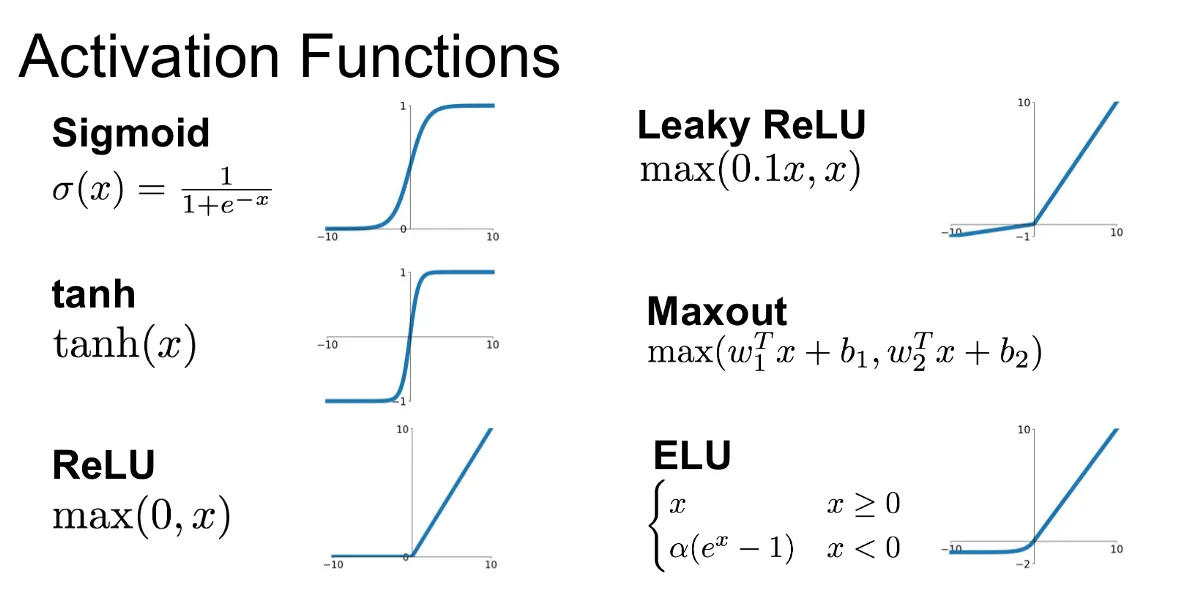

출처: https://wikidocs.net/250622

In [ ]:
print("모델 요약:")
model.summary() # Param == 입력 X 출력 + 출력


모델 요약:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 학습
history = model.fit(독립변수_전체_스케일링, 종속변수,
                   epochs=200,
                   verbose=0,
                   validation_split=0.2)  # 20%를 검증 데이터로 사용

# 마지막 10 에포크만 출력
model.fit(독립변수_전체_스케일링, 종속변수,
         epochs=10,
         validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 652727.9375 - val_loss: 832747.8125
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 652625.5000 - val_loss: 832615.1250
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 652522.5000 - val_loss: 832481.7500
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 652418.8125 - val_loss: 832347.4375
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 652314.6250 - val_loss: 832212.3750
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 652209.7500 - val_loss: 832076.6875
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 652104.3750 - val_loss: 831940.0625
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 651998.3750 - val_loss: 831802.9375
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 651891.7500 - val_loss: 831664.8750
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 651784.6250 - val_loss: 831526.1250


<ipython-input-15-826b3e5d18c5>:11: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.savefig('학습과정.png')
<ipython-input-15-826b3e5d18c5>:11: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.savefig('학습과정.png')
<ipython-input-15-826b3e5d18c5>:11: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.savefig('학습과정.png')
<ipython-input-15-826b3e5d18c5>:11: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.savefig('학습과정.png')
<ipython-input-15-826b3e5d18c5>:11: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.savefig('학습과정.png')
<ipython-input-15-826b3e5d18c5>:11: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.savefig('학습과정.png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE

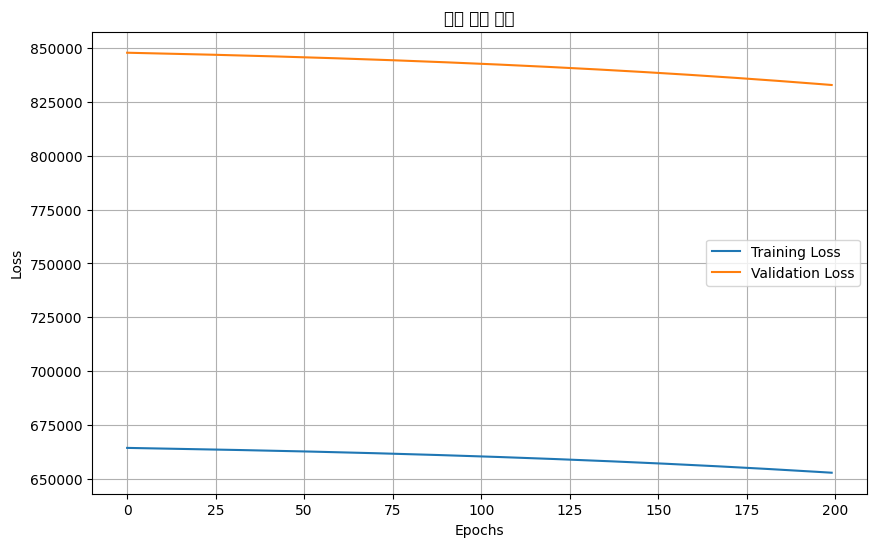

In [ ]:
# 학습 과정 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('모델 학습 과정')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('학습과정.png')
plt.show()

In [ ]:
# 가중치 확인
weights = model.get_weights()
weights

[array([[-0.55159974,  0.14445686,  0.6102837 , -0.04713194,  0.02503177,
          0.12797256,  0.24208821,  0.2719733 ,  0.8013738 , -0.36523926],
        [ 0.07416916, -0.56357497,  0.75125164,  0.4832418 ,  0.73160255,
          0.6197535 , -0.4887125 , -0.16149534,  0.54407656, -0.46275097],
        [-0.4989305 ,  0.43675685,  0.02009771,  0.5765043 ,  0.06166307,
          0.7102243 , -0.23413083, -0.31447458, -0.16707718, -0.18238074],
        [ 0.26303905, -0.2776269 ,  0.55097723,  0.67471606, -0.14661317,
          0.45297772,  0.31764522, -0.03740578,  0.3048698 , -0.09045213],
        [ 0.50798345,  0.31803858,  0.3202238 ,  0.30886933, -0.04488122,
          0.15704437, -0.07077968, -0.31008777,  0.39223567,  0.06476611],
        [ 0.48454309,  0.23515576,  0.7549027 ,  0.09271646, -0.16751301,
          0.20940398, -0.3359282 , -0.19564989,  0.03382206,  0.33821273],
        [-0.44942248, -0.41824698, -0.09723514,  0.69568425,  0.47599038,
         -0.27129862, -0.1794120

In [ ]:
# 실습 4: 새로운 데이터로 예측해보기
# 예: 면적 105, 침실수 3, 건축년도 2019, 지역 '홍대'
새_면적 = 105
새_침실수 = 3
새_건축년도 = 2019
새_지역 = '홍대'

In [ ]:
# 특성 스케일링 적용
새_면적_스케일링 = 새_면적 / 100
새_건축년도_스케일링 = (새_건축년도 - 2000) / 20

In [ ]:
# 새 데이터에 대한 원핫인코딩 생성
지역_리스트 = ['강남', '송파', '영등포', '홍대']
새_지역_원핫 = [1 if r == 새_지역 else 0 for r in 지역_리스트]

In [ ]:
# 예측용 입력 데이터 준비
새_입력 = np.array([[새_면적_스케일링, 새_침실수, 새_건축년도_스케일링] + 새_지역_원핫])

# 예측
예측_가격 = model.predict(새_입력)
print(f"\n새 데이터 예측: 면적 {새_면적}㎡, 침실수 {새_침실수}, 건축년도 {새_건축년도}, 지역 '{새_지역}'")
print(f"예측 가격: {예측_가격[0][0]:.0f} 백만원")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

새 데이터 예측: 면적 105㎡, 침실수 3, 건축년도 2019, 지역 '홍대'
예측 가격: 10 백만원


In [ ]:
# SavedModel 형식으로 저장
model.save('my_model')  # 디렉토리에 저장됨 <-- Django 등에서 사용할 수 있음
'''
# Django 등에서 아래와 같이 사용할 수 있음

MODEL_PATH = os.path.join(BASE_DIR, 'myapp', 'ml_models', 'my_model')
get_model.model = tf.keras.models.load_model(MODEL_PATH)
get_model.model.predict(새_입력)
'''